In [45]:
import polars as pl
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
import re
import os
from importlib import reload
logging.getLogger('matplotlib.font_manager').disabled = True
from importlib import reload

import pandas as pd



In [76]:
file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/EnergieUebersichtCH-2024.xlsx"
#35158
df = pd.read_excel(file_path, sheet_name='Zeitreihen0h15', skiprows=2, nrows=35156, header=None)

cols_to_extract = [0,1,2,3]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['Zeitstempel', 'Summe_Produziert', 'Summe_Endverbrauch', 'Summe_Verbrauch']


extracted_df = pl.from_pandas(extracted_df)

print(extracted_df)



shape: (35_136, 4)
┌──────────────────┬──────────────────┬────────────────────┬─────────────────┐
│ Zeitstempel      ┆ Summe_Produziert ┆ Summe_Endverbrauch ┆ Summe_Verbrauch │
│ ---              ┆ ---              ┆ ---                ┆ ---             │
│ str              ┆ f64              ┆ f64                ┆ f64             │
╞══════════════════╪══════════════════╪════════════════════╪═════════════════╡
│ 01.01.2024 00:15 ┆ 1.4438e6         ┆ 1.2964e6           ┆ 1.9392e6        │
│ 01.01.2024 00:30 ┆ 1.4424e6         ┆ 1.2941e6           ┆ 1.9219e6        │
│ 01.01.2024 00:45 ┆ 1.4326e6         ┆ 1.2894e6           ┆ 1.9144e6        │
│ 01.01.2024 01:00 ┆ 1.4205e6         ┆ 1.2844e6           ┆ 1.9172e6        │
│ 01.01.2024 01:15 ┆ 1.4459e6         ┆ 1.2914e6           ┆ 1.9705e6        │
│ …                ┆ …                ┆ …                  ┆ …               │
│ 31.12.2024 23:00 ┆ 1.6586e6         ┆ 1.3948e6           ┆ 1.9149e6        │
│ 31.12.2024 23:15 ┆ 1.6782e6    

In [85]:
def day_avg_preprocess(df):
    # Parse the timestamp column (assuming 'timestamp' column exists)
    df = df.with_columns(
        pl.col("Zeitstempel").str.strptime(pl.Datetime, format="%d.%m.%Y %H:%M", strict=False).alias("zeitpunkt_dt")
    )
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    # Group by time_of_day across all days in the range and average the energy column
    day_avg = (
        df.group_by("time_of_day")
            .agg([
                    pl.col("Summe_Produziert").mean(),
                    pl.col("Summe_Endverbrauch").mean(),
                    pl.col("Summe_Verbrauch").mean()
                ])
          .sort("time_of_day")
    )
    
    return day_avg

time_avg = day_avg_preprocess(extracted_df)

    

shape: (96, 4)
┌─────────────┬──────────────────┬────────────────────┬─────────────────┐
│ time_of_day ┆ Summe_Produziert ┆ Summe_Endverbrauch ┆ Summe_Verbrauch │
│ ---         ┆ ---              ┆ ---                ┆ ---             │
│ time        ┆ f64              ┆ f64                ┆ f64             │
╞═════════════╪══════════════════╪════════════════════╪═════════════════╡
│ 00:00:00    ┆ 1.3772e6         ┆ 1.9379e6           ┆ 1.5684e6        │
│ 00:15:00    ┆ 1.3973e6         ┆ 1.9154e6           ┆ 1.6089e6        │
│ 00:30:00    ┆ 1.3798e6         ┆ 1.8938e6           ┆ 1.5953e6        │
│ 00:45:00    ┆ 1.3575e6         ┆ 1.8752e6           ┆ 1.5755e6        │
│ 01:00:00    ┆ 1.3277e6         ┆ 1.8513e6           ┆ 1.5543e6        │
│ …           ┆ …                ┆ …                  ┆ …               │
│ 22:45:00    ┆ 1.4921e6         ┆ 2.1879e6           ┆ 1.6412e6        │
│ 23:00:00    ┆ 1.4600e6         ┆ 2.1421e6           ┆ 1.6147e6        │
│ 23:15:00    ┆ 1.4598e

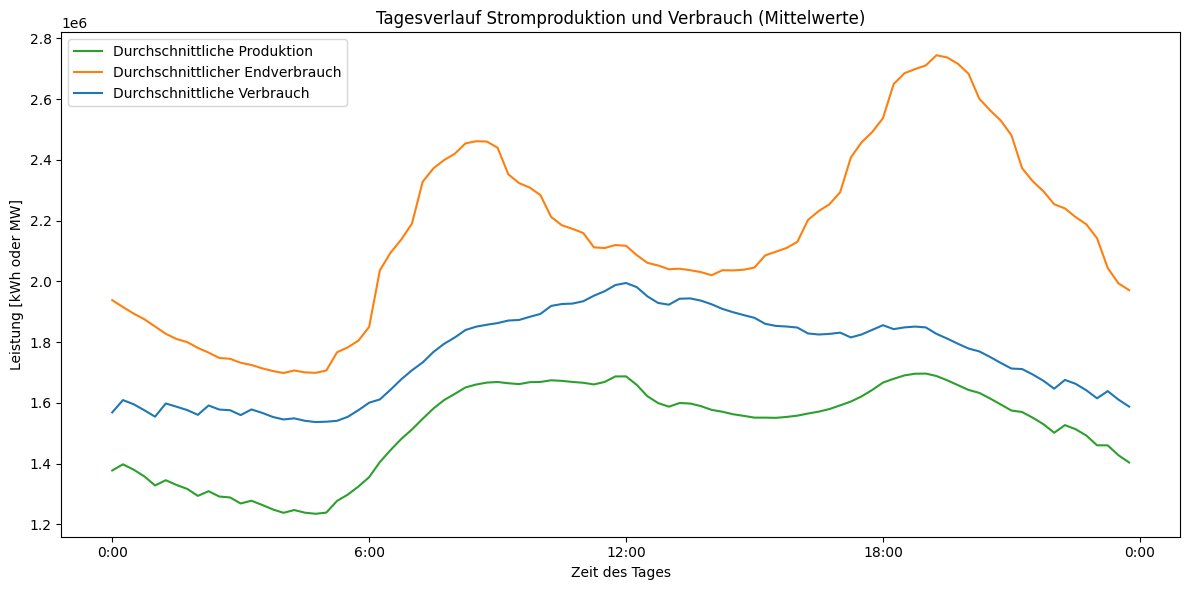

In [94]:
print(time_avg)

pd_time_avg = time_avg.to_pandas()

labels = ['0:00','6:00','12:00','18:00','0:00']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

# Zeitachse (= 'time_of_day') als x-Achse übernehmen und alle drei Werte plotten:
plt.figure(figsize=(12,6))
plt.plot(range(1,97), pd_time_avg['Summe_Produziert'], label='Durchschnittliche Produktion', color=colors[2])
plt.plot(range(1,97), pd_time_avg['Summe_Endverbrauch'], label='Durchschnittlicher Endverbrauch', color=colors[1])
plt.plot(range(1,97), pd_time_avg['Summe_Verbrauch'], label='Durchschnittliche Verbrauch', color=colors[0])
plt.xlabel("Zeit des Tages")
plt.ylabel("Leistung [kWh oder MW]")
plt.title("Tagesverlauf Stromproduktion und Verbrauch (Mittelwerte)")
plt.legend()
#plt.ylim(0,2000000)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
plt.show()